In [1]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

In [2]:
import pyspark.sql.functions as F

In [3]:
lending = spark.read.csv('accepted_2007_to_2018Q4.csv.gz', inferSchema=True, header=True)
lending.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: double (nullable = true)
 |-- funded_amnt: double (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

## Decide on categories for features
loan_amnt, funded_amnt, term, int_rate, grade, emp_length, home_ownership, annual_inc, addr_state?, fico_range_low (there's no point in using both FICO fields, they are close together and highly correlated), what else??

In [13]:
lending.select('loan_status').distinct().show(20, False) #shows different loan statuses
#modified to show full status.

+---------------------------------------------------+
|loan_status                                        |
+---------------------------------------------------+
|Fully Paid                                         |
|Default                                            |
|null                                               |
|In Grace Period                                    |
|Does not meet the credit policy. Status:Fully Paid |
|Charged Off                                        |
|Oct-2015                                           |
|Late (31-120 days)                                 |
|Current                                            |
|Does not meet the credit policy. Status:Charged Off|
|Late (16-30 days)                                  |
+---------------------------------------------------+



Response variable is loan_status. We'll need to change to a binary with 'Default', 'Charged Off', and 'Does not meet the credit policy. Status:Charged Off' can be 1 for default and the others can be 0 for not defaulted. Null rows will need to be deleted.

In [26]:
# Show counts of each loan status.. and percentage
#
from pyspark.sql.functions import avg, round
lending_status = lending.select('loan_status')
total_rec = lending.count()
lending_stat_grp = lending_status.groupBy('loan_status').count()
lending_stat_grp = lending_stat_grp.withColumn('percentage', lending_stat_grp['count']/total_rec * 100)
#c = 'percentage'
lending_stat_grp.show(20,False) # I need to round this column but haven't figured that out yet also the 20



+---------------------------------------------------+-------+---------------------+
|loan_status                                        |count  |percentage           |
+---------------------------------------------------+-------+---------------------+
|Fully Paid                                         |1076751|47.629076114001805   |
|Default                                            |40     |0.0017693626888297036|
|null                                               |33     |0.0014597242182845054|
|In Grace Period                                    |8436   |0.37315859107418453  |
|Does not meet the credit policy. Status:Fully Paid |1988   |0.08793732563483626  |
|Charged Off                                        |268558 |11.87941262466819    |
|Oct-2015                                           |1      |4.4234067220742594E-5|
|Late (31-120 days)                                 |21467  |0.9495727210276812   |
|Current                                            |878317 |38.851533219120

In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [34]:
statuses = lending_stat_grp.select("loan_status").rdd.flatMap(lambda x: x).collect()
statuses[2]="None" # since Plotting doesn't like None
status_counts =  lending_stat_grp.select("count").rdd.flatMap(lambda x: x).collect()
#not sure why this takes forever

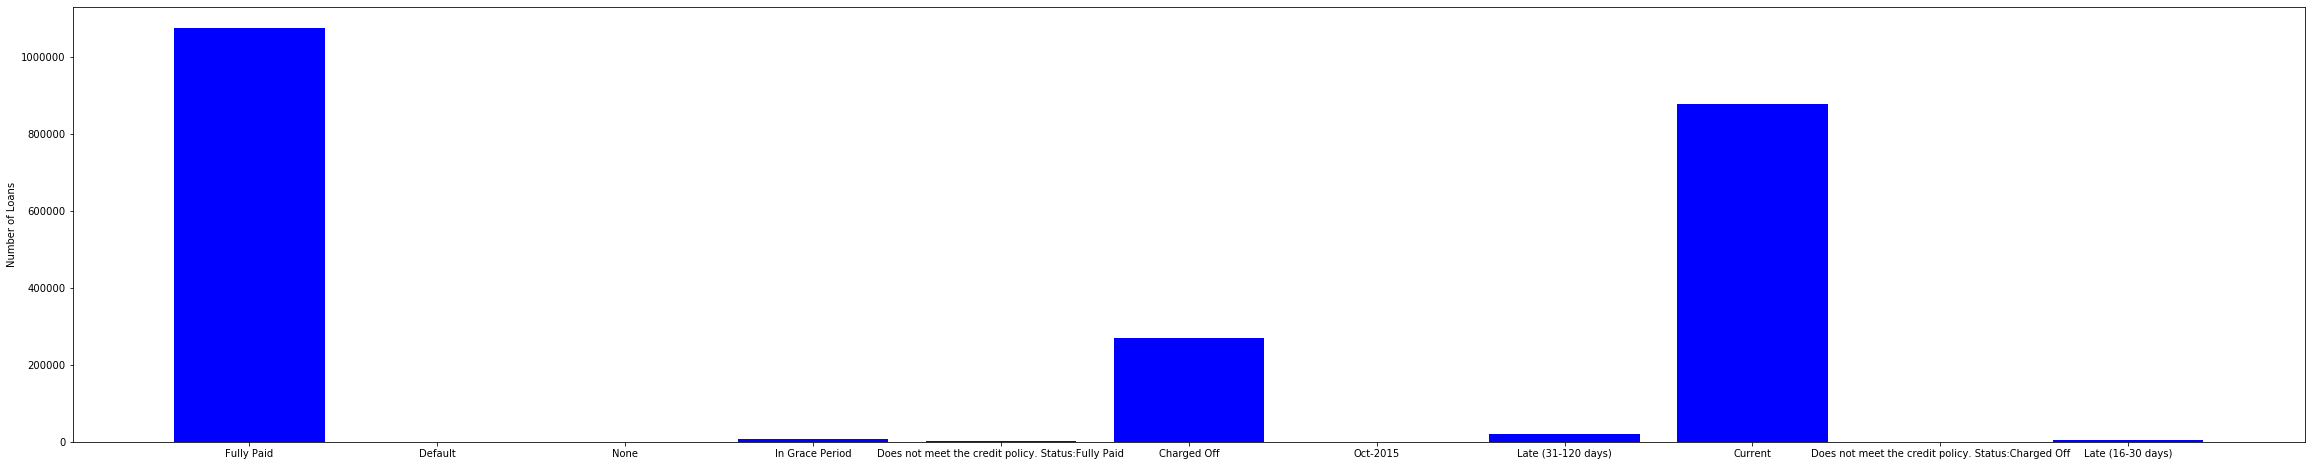

In [47]:
# Plotting Response Variable
plt.figure(figsize=(40,8))
plt.bar(statuses, status_counts, width=0.8, label='Loan Status', color='blue')
#plt.xticks(ind, labels)
plt.ylabel("Number of Loans")
plt.show()
#we can see the majority of our data set is current and fully paid. With Charged off being the 3rd largest

In [51]:
#making loan status binary 1: Default 0: Current
lending = lending.withColumn('loan_status_binary', F.when( (lending['loan_status'] == 'Default') | \
                                            (lending['loan_status'] == 'Charged Off') | \
                                            (lending['loan_status'] == 'Charged off and Does not meet the credit policy.'),1).otherwise(0))


In [52]:
lending.groupBy('loan_status_binary').count().show()

+----+-------+
|test|  count|
+----+-------+
|   1| 268598|
|   0|1992103|
+----+-------+



In [ ]:
df_train = lending.select(['loan_amnt', 'funded_amnt', 'term', 'int_rate', 'grade', 'emp_length',
                          'home_ownership', 'annual_inc', 'addr_state', 'fico_range_low'])

In [11]:
# for each field, compute missing percentage

df_train.agg(*[
    (1 - F.count(c) / F.count('*')).alias(c + '_miss')
    for c in df_train.columns
]).show()

+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|      loan_amnt_miss|    funded_amnt_miss|           term_miss|       int_rate_miss|          grade_miss|    emp_length_miss| home_ownership_miss|     annual_inc_miss|     addr_state_miss| fico_range_low_miss|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+
|1.459724218288993...|1.459724218288993...|1.459724218288993...|1.459724218288993...|1.459724218288993...|0.06499753837415911|1.459724218288993...|1.636660487169816...|1.503958285509199...|1.503958285509199...|
+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+--------------------+---------